In [1]:
#Importing needed packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.optim as optim
import time

torch.manual_seed(0)

In [2]:
#Plotting function
def view_classify(img, ps):

    ps = ps.cpu().data.numpy().squeeze()
    img= img.cpu().data.numpy()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.reshape(1, 28, 28).squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [3]:
transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5))])

trainset=datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader=DataLoader(trainset, batch_size=32, shuffle=True)

testset=datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader=DataLoader(testset, batch_size=32, shuffle=False)

In [4]:
dataiter=iter(trainloader)
images, labels=dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


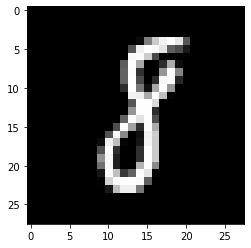

In [5]:
plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [6]:
class Network(nn.Module):
    def __init__(self):
        super(Network, self).__init__()
        self.conv1=nn.Conv2d(1, 32, 5, padding=1, stride=2)
        self.pool=nn.MaxPool2d(2,2)

        self.conv2=nn.Conv2d(32, 16, 5)
        self.fc1=nn.Linear(16*1*1, 128)
        self.fc2=nn.Linear(128, 64)
        self.fc3=nn.Linear(64,10)

    def forward(self, x):
        #print(x.shape)
        x=self.pool(F.relu(self.conv1(x)))
        x=self.pool(F.relu(self.conv2(x)))
        #print(x.shape)
        x=x.view(x.shape[0], -1)
        x=F.relu(self.fc1(x))
        x=F.relu(self.fc2(x))
        x=self.fc3(x)
        #x=F.softmax(x, dim=1)
        return x

model=Network()

In [7]:
device='cuda' if torch.cuda.is_available() else 'cpu'
print(device)
model.to(device)

cuda


Network(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

Epoch: 1/20
Mean epoch loss for train: 2.141864098485311
Mean epoch loss for test: 2.0939245231616233
accuracy on epoch: 0.6223043130990416
Epoch: 2/20
Mean epoch loss for train: 0.5389271832287311
Mean epoch loss for test: 1.575828365243662
accuracy on epoch: 0.9384984025559105
Epoch: 3/20
Mean epoch loss for train: 0.1887909521152576
Mean epoch loss for test: 1.5276998890855442
accuracy on epoch: 0.9604632587859425
Epoch: 4/20
Mean epoch loss for train: 0.1340141078280906
Mean epoch loss for test: 1.5116886445127737
accuracy on epoch: 0.9698482428115016
Epoch: 5/20
Mean epoch loss for train: 0.11025429216002425
Mean epoch loss for test: 1.5099822884550491
accuracy on epoch: 0.9698482428115016
Epoch: 6/20
odict_keys(['conv1.weight', 'conv1.bias', 'conv2.weight', 'conv2.bias', 'fc1.weight', 'fc1.bias', 'fc2.weight', 'fc2.bias', 'fc3.weight', 'fc3.bias'])
Mean epoch loss for train: 0.09419606625499825
Mean epoch loss for test: 1.5008851251663111
accuracy on epoch: 0.9760383386581469
Epo

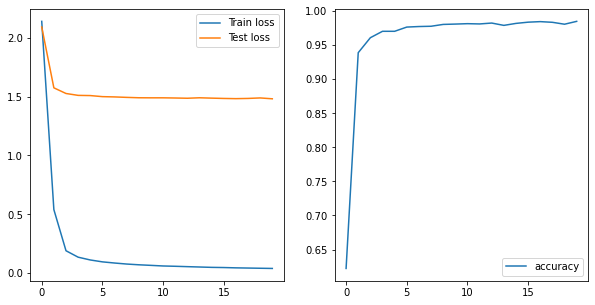

In [8]:
criterion=nn.CrossEntropyLoss()
start_time=time.time()
def torch_fit(trainloader, testloader, criterion, lr, num_epochs, model, device):
    optimizer=optim.SGD(model.parameters(), lr)

    train_losses=[]
    test_losses=[]
    accuracy=[]
    norm_score=0.97
    for epoch in range(num_epochs):
        print(f'Epoch: {epoch+1}/{num_epochs}')

        train_epoch_loss=[]
        for i, (images, labels) in enumerate(iter(trainloader)):
            images=images.to(device)
            labels=labels.to(device)
            optimizer.zero_grad()
            pred=model.forward(images)
            loss=criterion(pred, labels)
            train_epoch_loss.append(loss.item())
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            
            test_epoch_list=[]
            acc_on_epoch=[]
            for j, (imagest, labelst) in enumerate(iter(testloader)):
                imagest=imagest.to(device)
                labelst=labelst.to(device)
                preds=F.softmax(model(imagest), dim=1)
                losst=criterion(preds, labelst)
                test_epoch_list.append(losst.item())

                acc_pred=preds.argmax(dim=1)
                acc=(acc_pred == labelst).sum()/ len(labelst)
                acc_on_epoch.append(acc.item())
    
        mean_acc=sum(acc_on_epoch)/len(acc_on_epoch)
        accuracy.append(mean_acc)

        test_loss_mean=sum(test_epoch_list)/len(test_epoch_list)
        test_losses.append(test_loss_mean)

        train_loss_mean=sum(train_epoch_loss)/len(train_epoch_loss)
        train_losses.append(train_loss_mean)


        if norm_score < mean_acc:#0.98
            torch.save(model.state_dict(),'checkpoint.pth')
            state_dict = torch.load('checkpoint.pth')
            print(state_dict.keys())
            norm_score = mean_acc

        model.train()
   

        print(f'Mean epoch loss for train: {train_loss_mean}')
        print(f'Mean epoch loss for test: {test_loss_mean}')
        print(f'accuracy on epoch: {mean_acc}')

    final_time = time.time()- start_time
    print(f'Training time took: {final_time}')

    x_axis_acc=list(range(num_epochs))
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train loss')
    plt.plot(test_losses, label='Test loss')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.plot(x_axis_acc,accuracy, label='accuracy')
    plt.legend()
    plt.show()

ans=torch_fit(trainloader=trainloader, testloader=testloader,criterion=criterion, lr=0.005, num_epochs=20, model=model, device=device)

In [8]:
state_dict=torch.load('checkpoint.pth')
model.load_state_dict(state_dict)
print(model.load_state_dict(state_dict))

<All keys matched successfully>


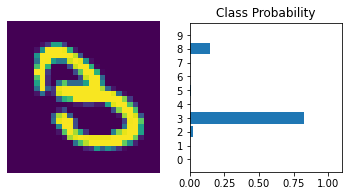

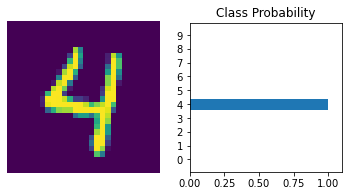

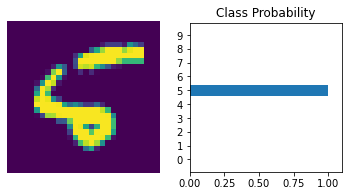

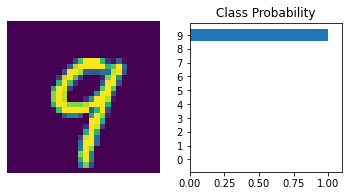

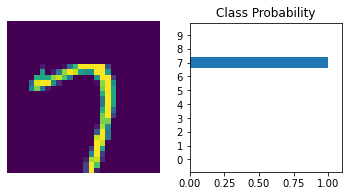

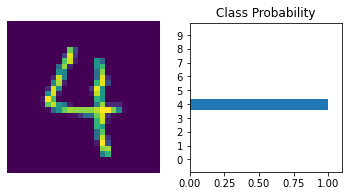

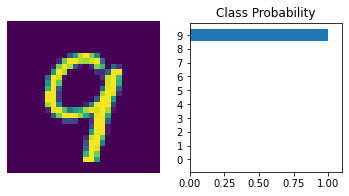

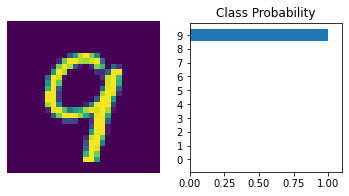

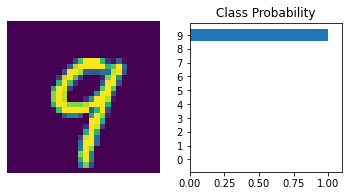

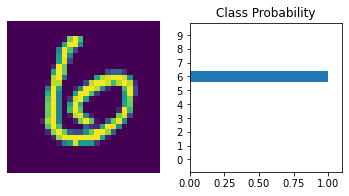

In [9]:
counter=0
while counter<10:
    index=np.random.randint(0,32)
    images, labels = next(iter(testloader))
    images=images.to(device)
    labels=labels.to(device)
    image=images[index]    
    logits = model.forward(image.view(1,1,28,28))
    ps = F.softmax(logits, dim=1)
    view_classify(image.view(1, 28, 28), ps)
    plt.show()
    time.sleep(1)
    counter+=1